In [1]:
import numpy as np
import re
import subprocess
import matplotlib.pyplot as plt
from tqdm import tqdm

import random

import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import tensorflow.keras as keras

from keras import initializers

from spektral.data import Dataset, DisjointLoader, Graph, SingleLoader
from spektral.layers import GCSConv, GlobalAvgPool, GlobalMaxPool, GeneralConv
from spektral.transforms.normalize_adj import NormalizeAdj

from gradient_accumulator import GradientAccumulateModel

%matplotlib notebook

In [6]:
# This section contains the functions used to turn our crystal lattice into a spektral-readable Graph object

def distance(pos1, pos2):
    return np.linalg.norm(pos1 - pos2)

def ToGraph(types, positions, tc, mass1, mass2):
    
#     mass1 = 500
#     mass2 = 50
    
    N = len(types)
    
    source = []
    target = []
    
    A = distance(positions[0], positions[1])
    
    for i in range(len(positions)):
        for j in range(len(positions)):
            if distance(positions[i], positions[j]) < A*0.999 and distance(positions[i], positions[j]) > 0.01:
                source.append(i)
                target.append(j)
                
    source, target = np.array(source), np.array(target)
    values = np.ones(len(source))
    
    coo = sp.coo_matrix((values, (source, target)))
    csr = sp.csr_matrix(coo)
    
    atom_mass = np.empty([N, 1])
    
    maxmass = np.max([mass1, mass2])
    
    for i in range(N):
        if types[i] == 1:
            atom_mass[i] = [mass1]
        if types[i] == 2:
            atom_mass[i] = [mass2]
            
    mygraph = Graph(x=atom_mass, a=coo, y=tc)
    return mygraph

In [7]:
#######################
# Txt editing functions
#######################

def extract_tc(file_path):
    '''
    Extracts the tc value from the lammps log file
    '''
    with open(file_path, 'r') as file:
        content = file.read()

    # Use a specific regular expression to find the second occurrence of 'average conductivity:'
    pattern = re.compile(r'average conductivity:\s*([\d.]+)\s*\[W/mK\]', re.IGNORECASE)
    matches = pattern.findall(content)
    if len(matches)>0:
        return float(matches[0])
    else:
        return 'A kutyafáját'
    
    
def update_vseed(file_path, new_value):
    '''
    Updates the seed for the velocity command in the LAMMPS input script
    '''
    target_pattern = re.compile(r'^\s*variable\s+r\s*equal\s*[\d.]+\s*$')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines
    with open(file_path, 'w') as file:
        # Iterate through each line
        for line in lines:
            # Check if the line matches the target pattern
            if target_pattern.match(line):
                # Replace the number with the new value
                line = f"variable r equal {new_value}\n"
            
            # Write the line to the file
            file.write(line)
            
def update_mass(file_path, new_value_mass1, new_value_mass2):
    '''
    Updates the mass 1 and mass 2 in the LAMMPS input script
    '''
    # Define target patterns for mass 1 and mass 2
    target_pattern_mass1 = re.compile(r'^\s*mass\s+1\s+[\d.]+\s*$')
    target_pattern_mass2 = re.compile(r'^\s*mass\s+2\s+[\d.]+\s*$')
    
    # Open the file in read mode to read all lines
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Open the file in write mode to update the lines
    with open(file_path, 'w') as file:
        # Iterate through each line
        for line in lines:
            # Check if the line matches the target pattern for mass 1
            if target_pattern_mass1.match(line):
                # Replace the number with the new value for mass 1
                line = f"mass 1 {new_value_mass1}\n"
            # Check if the line matches the target pattern for mass 2
            elif target_pattern_mass2.match(line):
                # Replace the number with the new value for mass 2
                line = f"mass 2 {new_value_mass2}\n"
            
            # Write the line to the file
            file.write(line)

In [8]:
################################
# 1.) Atom type array generators
################################

def mixatom_type2(size, proportion_of_ones, seed):
    
    """
    For BCC
    """
    
    N = np.product(size) * 2
    num_ones = int(N * proportion_of_ones)
    num_twos = N - num_ones

    # Generate an array with ones and twos
    # np.random.seed(0) So this was silly
    np.random.seed(seed)
    mixed_array = np.random.choice([1, 2], size=N, replace=True, p=[proportion_of_ones, 1 - proportion_of_ones])

    return mixed_array

In [9]:
#############################
# 2.) LAMMPSify main function
#############################

# LAMMPS parameter order:
# ID, group, type, charge, x, y, z


def LAMMPSify(filename, positions, types, size):
    N = len(positions)
    
    # Generate ID, group, type, and charge arrays
    IDs     = np.array(range(1, N+1))
    groups  = np.ones(N)
    
    charges = np.zeros(N)
    
    # Combine ID, group, type, charge with positions
    data = np.column_stack((IDs, types, positions))
    
    np.savetxt(filename, data, fmt = '%i %i %s %s %s',header = 
f'''# Title

{len(data)} atoms

{len(np.unique(data[:,1]))} atom types

0.0 {max(positions[:,0])} xlo xhi
0.0 {max(positions[:,1])} ylo yhi
0.0 {max(positions[:,2])} zlo zhi

Atoms
''', comments = '')
    
    return

In [10]:
##############################
# 3.) Atom position generators
##############################

def generate_bcc(size, constant):
    sc1 = np.meshgrid(range(size[0]), range(size[1]), range(size[2]))
    sc1 = np.transpose(sc1).reshape(np.product(size), 3)
    
    sc2 = sc1 + np.array([0.5, 0.5, 0.5])
    
    bcc = np.vstack((sc1, sc2)) * constant
    
    return bcc

In [11]:
#############
# Bash runner
#############

def run_bash():
    !bash {'lammps.sh'}
    return

In [27]:
#############
# Load data
#############
class MyDataset(Dataset):
    """
    Implement 'read' that returns a list of graphs
    """

    def __init__(self, types, pos, tc, mass1, mass2, **kwargs):
        self.types = types
        self.pos   = pos
        self.tc    = tc
        self.mass1 = mass1
        self.mass2 = mass2
        super().__init__(**kwargs)

    
    
    def read(self):
        
        GraphList = []
        
        if type(self.tc) == float:
            GraphList.append(ToGraph(self.types, self.pos, self.tc, self.mass1, self.mass2))
            
        else:
            for i in range(len(self.tc)):
                GraphList.append(ToGraph(self.types[i], self.pos, self.tc[i], self.mass1[i], self.mass2[i]))
        
        return GraphList

In [28]:
###################
# Global variables
###################
mass_old = np.linspace(100, 300, 11)
mass2 = [element for element in mass_old for _ in range(100)]
mass1 = np.ones(1100) * 50



n_samples = len(mass1) # no. of Graph objects

size = np.array([2, 2, 2]) # size of Graph

np.random.seed(42)  # fix the seed

vseed = np.random.randint(1, 10000, n_samples)
iseed = np.random.randint(1, 10000, n_samples)

lattice_c = 4.3

types = np.array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2])
positions = generate_bcc(size, lattice_c)

len(mass2)

1100

In [29]:
#############
# ML config
#############

learning_rate = 1e-4  # Learning rate
epochs = 50   # Number of training epochs
es_patience = 100  # Patience for early stopping
batch_size = 10  # Batch size

In [22]:
GraphList = []
typelist  = []
tclist    = []

for i in tqdm(range(n_samples)):
        pos   = generate_bcc(size, lattice_c)
        # types = mixatom_type2(size, atom_ratios[i], iseed[i])
        # types = mixatom_type2(size, 1, iseed[i])
            
        LAMMPSify('datafile.txt', pos, types, size)
            
        update_vseed('tc.txt', vseed[i])
        
        update_mass('tc.txt', mass1[i], mass2[i])
        run_bash()
        tc = extract_tc('log.lammps')
            
        # GraphList.append(ToGraph(types, pos, tc, mass1[i]))
        tclist.append(tc)
        typelist.append(types)
        
def swap_string(lst):
    for i in range(len(lst)):
        if lst[i] == "A kutyafáját":
            lst[i] = 0.5
            print("Swapped!")
            
    return lst

swap_string(tclist)

np.savetxt('tclist_small_mix.txt', tclist)

np.array(typelist).shape
# np.savetxt('typelist_small2.txt', np.array(typelist))
print(tclist)

100%|████████████████████████████████████████████████████████████████████████████| 1100/1100 [3:10:23<00:00, 10.39s/it]

Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
Swapped!
[222.601952733266, 234.604352649698, 278.880848235297, 218.313492816673, 342.785586886018, 320.567660123722, 333.538568883836, 360.010432512949, 300.719297528155, 308.009093742537, 350.011739792604, 323.115266240481, 340.281242557674, 213.730538099174, 294.050509659973, 191.937862424768, 353.733351122952, 288.403063973001, 324.352865991151, 349.137061163471, 291.216640379907, 401.494374027918, 213.397900488728, 332.04963395874, 368.870325

<IPython.core.display.Javascript object>


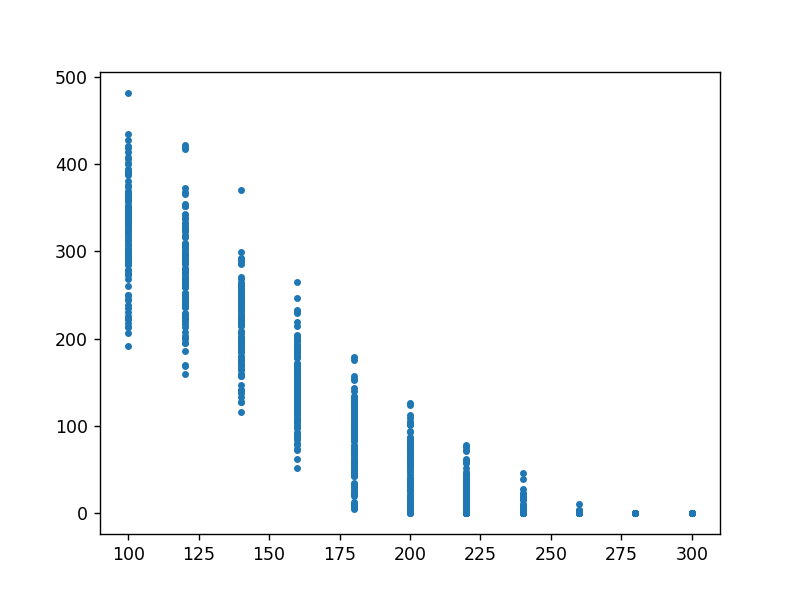

In [30]:
plt.figure()
plt.plot(mass2, tclist, '.')
#plt.ylim(0, 4)


        

<IPython.core.display.Javascript object>


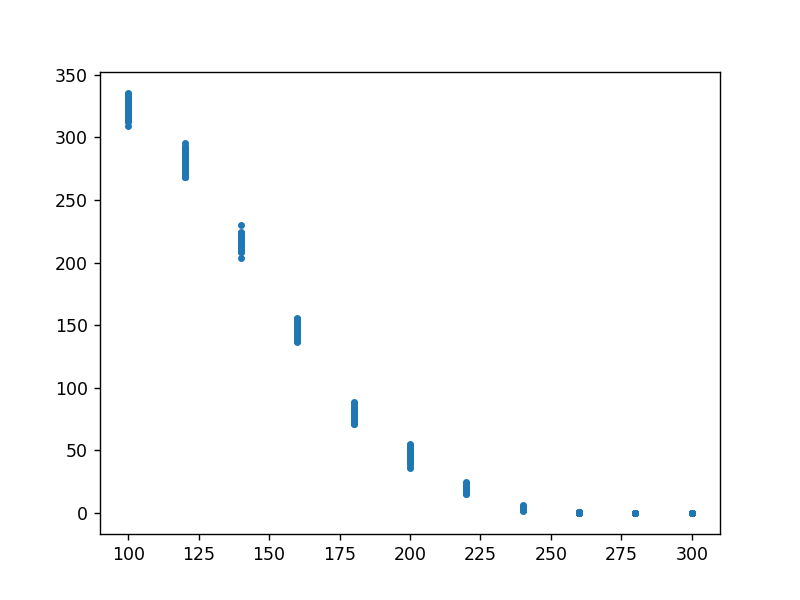

In [31]:
def average10(array):
    N = int(len(array))
    avg_array = np.empty(N)
    for i in range(int(N/100)):
        for j in range(100):
            avg_array[100*i+j] = np.mean(random.sample(array[i*100:(i+1)*100], 50))
        
    return avg_array

mass_avg = average10(mass2)
tc_avg   = average10(tclist)

plt.figure()
plt.plot(mass_avg, tc_avg, '.')

typelist = []
for _ in range(1100):
    typelist.append(types)

pos       = generate_bcc(size, lattice_c)
data_root = MyDataset(typelist, pos, tc_avg, mass1, mass_avg)

In [32]:
# Train/valid/test split
data = data_root

tf.random.set_seed(42)

idxs = np.random.permutation(len(data))
split_va, split_te = int(0.8 * len(data)), int(0.9 * len(data))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
data_tr = data[idx_tr]
data_va = data[idx_va]
data_te = data[idx_te]

# Data loaders
loader_tr = DisjointLoader(data_tr, batch_size=batch_size, epochs=epochs)
loader_va = DisjointLoader(data_va, batch_size=batch_size)
loader_te = DisjointLoader(data_te, batch_size=batch_size, epochs=1)

################################################################################
# Build model
################################################################################
class Net(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = GeneralConv(32, activation='PReLU', kernel_initializer=initializers.glorot_uniform(seed=0))
        self.conv2 = GeneralConv(250, activation='PReLU', kernel_initializer=initializers.glorot_uniform(seed=0))
        self.conv3 = GeneralConv(250, activation='PReLU', kernel_initializer=initializers.glorot_uniform(seed=0))
        self.global_pool = GlobalMaxPool()
        # self.global_pool = spektral.layers.GlobalAttentionPool(channels = 50)
        self.dense1 = Dense(200, activation="PReLU", kernel_initializer=initializers.glorot_uniform(seed=0))
        self.dense2 = Dense(50, activation="PReLU", kernel_initializer=initializers.glorot_uniform(seed=0))
        self.dense3 = Dense(1, activation=None, kernel_initializer=initializers.glorot_uniform(seed=0))

    def call(self, inputs):
        x, a, i = inputs        
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        x = self.conv3([x, a])
        x = self.global_pool([x, i])
        x = self.dense1(x)
        x = self.dense2(x)
        output = self.dense3(x)

        return output


model = Net()
# model = GradientAccumulateModel(accum_steps=4, inputs=model.input, outputs=model.output)
optimizer = Adam(learning_rate=learning_rate)
loss_fn = MeanSquaredError()

################################################################################
# Fit model
################################################################################
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        # print(f'predictions: {predictions}')
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss


def evaluate(loader):
    output = []
    step = 0
    while step < loader.steps_per_epoch:
        step += 1
        inputs, target = loader.__next__()
        pred = model(inputs, training=False)
        outs = (
            loss_fn(target, pred),
            tf.reduce_mean(categorical_accuracy(target, pred)),
            len(target),  # Keep track of batch size
        )
        output.append(outs)
        if step == loader.steps_per_epoch:
            output = np.array(output)
            return np.average(output[:, :-1], 0, weights=output[:, -1])


epoch = step = 0
best_val_loss = np.inf
best_weights = None
patience = es_patience
results = []
for batch in loader_tr:
    step += 1
    # print(step)
    loss = train_step(*batch)
    results.append(loss)
    if step == loader_tr.steps_per_epoch:
        step = 0
        epoch += 1

        # Compute validation loss and accuracy
        val_loss = evaluate(loader_va)
        print(f"Ep. {epoch} - Loss: {np.mean(results)} - Val loss: {val_loss[0]}")

        # Check if loss improved for early stopping
        if val_loss[0] < best_val_loss:
            best_val_loss = val_loss[0]
            patience = es_patience
            print(f"New best val_loss {best_val_loss}")
            best_weights = model.get_weights()
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping (best val_loss: {best_val_loss})")
                break
        results = []
        
################################################################################
# Evaluate model
################################################################################
tc_ml_list = []
tc_ta_list = []

loss = 0
for batch in loader_te:
    inputs, target = batch
    tc_ta_list.append(target)
    # print(inputs, target)
    predictions = model(inputs, training=False)
    tc_ml_list.append(predictions.numpy().ravel())
    loss += loss_fn(target, predictions)
    print('iteration')
loss /= loader_te.steps_per_epoch
print("Done. Test loss: {}".format(loss))

C:\Users\Lenovo\anaconda3\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Ep. 1 - Loss: 11010.208984375 - Val loss: 24991.469992897728
New best val_loss 24991.469992897728
Ep. 2 - Loss: 2394.09375 - Val loss: 5548.978781960227
New best val_loss 5548.978781960227
Ep. 3 - Loss: 1298.7103271484375 - Val loss: 1413.1451970880682
New best val_loss 1413.1451970880682
Ep. 4 - Loss: 1548.21240234375 - Val loss: 543.4400301846591
New best val_loss 543.4400301846591
Ep. 5 - Loss: 1199.6141357421875 - Val loss: 224.5439234646884
New best val_loss 224.5439234646884
Ep. 6 - Loss: 975.203857421875 - Val loss: 186.13253714821556
New best val_loss 186.13253714821556
Ep. 7 - Loss: 807.2640380859375 - Val loss: 64.88998291709207
New best val_loss 64.88998291709207
Ep. 8 - Loss: 932.6000366210938 - Val loss: 90.7535778392445
Ep. 9 - Loss: 793.3956909179688 - Val loss: 92.23204976862127
Ep. 10 - Loss: 931.4629516601562 - Val loss: 72.87748856977983
Ep. 11 - Loss: 748.860107421875 - Val loss: 53.74092388153076
New best val_loss 53.74092388153076
Ep. 12 - Loss: 649.9691772460938 

<IPython.core.display.Javascript object>


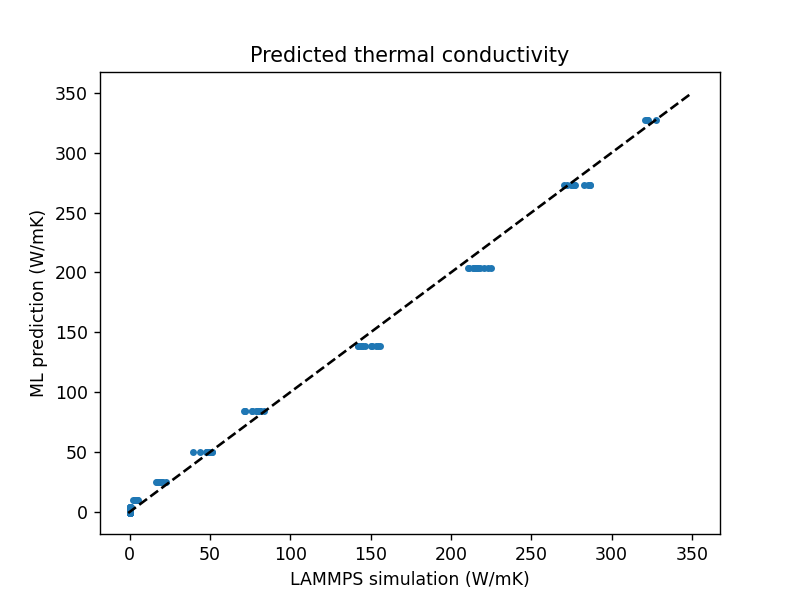

In [35]:
plt.figure()
plt.plot(np.concatenate(np.array(tc_ta_list)),np.concatenate(np.array(tc_ml_list)), '.')
plt.plot([-1, 350], [-1, 350], '--', c='black')
# plt.xlim(-1,10)
# plt.ylim(-1,10)
plt.ylabel('ML prediction (W/mK)')
plt.xlabel('LAMMPS simulation (W/mK)')

plt.title('Predicted thermal conductivity')
plt.savefig('MLmix.png')

In [453]:
print(np.concatenate(np.array(tc_ta_list)))
print(np.concatenate(np.array(tc_ml_list)))

[[7.75113370e-02]
 [1.38570986e-02]
 [6.84029630e-01]
 [1.49559217e+00]
 [2.48440101e-02]
 [6.58625059e-02]
 [1.67937616e-02]
 [1.94251766e-02]
 [7.60872433e-02]
 [3.03284881e-02]
 [1.06868497e-01]
 [1.07360894e-02]
 [5.00000000e-01]
 [2.19452130e+00]
 [1.96401853e-02]
 [5.08526280e-01]
 [2.79476911e-02]
 [5.00000000e-01]
 [1.43813056e+01]
 [6.23903052e-02]]
[ 0.09384754  0.1071409  -0.17058448  0.06628689  0.3930003   0.1561198
  0.23637298  0.02743375  0.20129107  1.1358907   0.6928979   0.19095986
  0.7275075   0.69080955  1.6283059   0.11804812  0.13732857  0.74586725
  2.1446388   1.1190745 ]


In [ ]:
loss = 0
for batch in loader_te:
    inputs, target = batch
    tc_ta_list.append(target)
    # print(inputs, target)
    predictions = model(inputs, training=False)
    tc_ml_list.append(predictions.numpy().ravel())
    loss += loss_fn(target, predictions)
    print('iteration')
loss /= loader_te.steps_per_epoch
print("Done. Test loss: {}".format(loss))